In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [4]:
test_size = 0.1
use_endpoint_prior = False
S_target = 379
lambda_end = 1e-4
dt = 1/252
N = 1000
T = 1

In [5]:
data = yf.Ticker("TSLA").history(start="2022-01-01", end="2024-01-01")[["Close"]]
test_size = int(len(data["Close"])-np.floor(len(data["Close"]) * test_size))

train = data[:test_size-1]
test = data[test_size:]
train.tail(5)
steps = len(test)

In [6]:
r = np.log(train["Close"] / train["Close"].shift()).dropna()

Estimated mu: -0.06197243146842185
Estimated sigma: 0.61794652086463
220.11000061035156
Predicted Final Price 251.87403264442014
Final Price 248.47999572753906
Optimal path index: 414


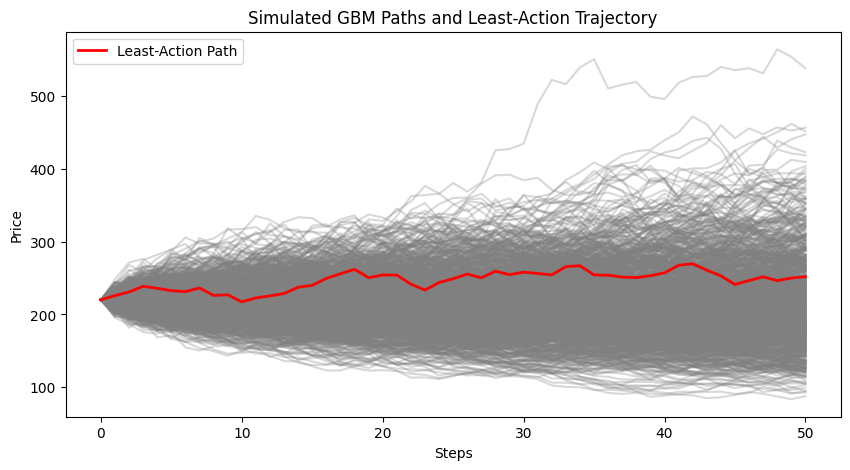

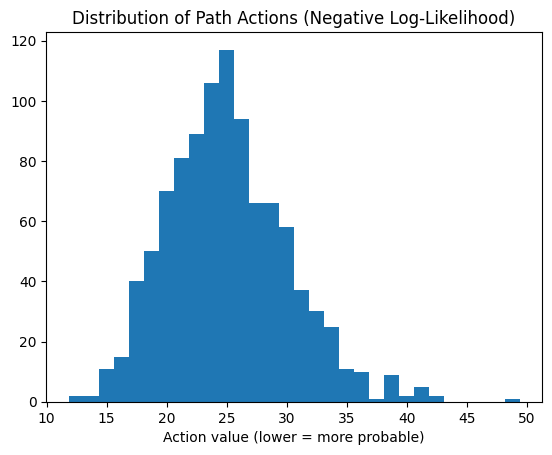

In [7]:
r_mean = r.mean()
r_std = r.std()

sigma = r_std / np.sqrt(dt)
mu = r_mean / dt + 0.5 * sigma**2

print("Estimated mu:", mu)
print("Estimated sigma:", sigma)

S0 = test["Close"].iloc[0]
print(S0)

paths = np.zeros((N, steps + 1))
paths[:, 0] = S0

for i in range(N):
    for t in range(steps):
        Z = np.random.randn()
        paths[i, t + 1] = paths[i, t] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)



actions = np.zeros(N)
var = (sigma**2) * dt 
m   = (mu - 0.5 * sigma**2) * dt


for i in range(N):
    S = paths[i, :]
    log_rets = np.log(S[1:] / S[:-1])
    actions[i] = np.sum((log_rets - m)**2 / (2 * var))
    if use_endpoint_prior and S_target is not None:
        actions[i] += lambda_end * (S[-1] - S_target)**2

optimal_index = np.argmin(actions)
optimal_path  = paths[optimal_index]
print("Predicted Final Price", optimal_path[-1])
print("Final Price", test["Close"][-1])
print("Optimal path index:", optimal_index)

plt.figure(figsize=(10, 5))
plt.plot(paths.T, color='gray', alpha=0.3)
plt.plot(optimal_path, color='red', linewidth=2, label='Least-Action Path')

plt.title("Simulated GBM Paths and Least-Action Trajectory")
plt.xlabel("Steps")
plt.ylabel("Price")
plt.legend()

plt.figure()
plt.hist(actions, bins=30)
plt.title("Distribution of Path Actions (Negative Log-Likelihood)")
plt.xlabel("Action value (lower = more probable)")
plt.show()
